# Empirical aDDM Generation

Model independent analysis confirmed that there are good and bad trends within Liu et al.'s (2025) simulated fixation data sampling from the gamma distribution. Following Tavares et al. (2017), we believe that better data can be generated empirically.

### Generating Empirical Data

In [1]:
import os, sys

DDM_dir = os.path.abspath('/Users/bchien37/Desktop/Enkavilab/DDM')
sys.path.append(DDM_dir)

dt = 0.001

In [2]:
from simulation import get_corrected_empirical_distributions
from ast import literal_eval
import numpy as np
import pandas as pd

df_raw = pd.read_csv('/Users/bchien37/Desktop/Enkavilab/DDM/1ms_trial_data.csv')
df_raw['choice'] = df_raw['choice'].map({'left':0,'right':1})
df_raw['RT'] = df_raw['RT'] / dt # adjustment for RT
df_raw['fixation'] = df_raw['fixation'].apply(literal_eval)

to_drop = pd.read_csv("/Users/bchien37/Desktop/Enkavilab/DDM/dropped_trials.csv").rename(columns={"parcode": "sub_id"})

df = df_raw[
    ~df_raw.set_index(["sub_id", "trial"]).index.isin(
        to_drop.set_index(["sub_id", "trial"]).index
    )
]

# num_data, _ = df.shape
num_data = 5000

value_diffs = np.unique(df['avgWTP_left'] - df['avgWTP_right'])
legend = {
    "left": {1},
    "right": {2},
    "transition": {0}, 
    "blank_fixation": {4}
}
fixation_col = 'fixation'
left_value_col = 'avgWTP_left'
right_value_col = 'avgWTP_right'

empirical_distributions = get_corrected_empirical_distributions(
    df,
    value_diffs=value_diffs,
    legend=legend,
    fixation_col=fixation_col,
    left_value_col=left_value_col,
    right_value_col=right_value_col,
    cutoff=0.9
)

In [14]:
list(empirical_distributions['fixations'][1].keys())

[np.float64(-4.0),
 np.float64(-3.75),
 np.float64(-3.5),
 np.float64(-3.25),
 np.float64(-3.0),
 np.float64(-2.75),
 np.float64(-2.5),
 np.float64(-2.25),
 np.float64(-2.0),
 np.float64(-1.75),
 np.float64(-1.5),
 np.float64(-1.25),
 np.float64(-1.0),
 np.float64(-0.75),
 np.float64(-0.5),
 np.float64(-0.25),
 np.float64(0.0),
 np.float64(0.25),
 np.float64(0.5),
 np.float64(0.75),
 np.float64(1.0),
 np.float64(1.25),
 np.float64(1.5),
 np.float64(1.75),
 np.float64(2.0),
 np.float64(2.25),
 np.float64(2.5),
 np.float64(2.75),
 np.float64(3.0),
 np.float64(3.25),
 np.float64(3.5),
 np.float64(3.75),
 np.float64(4.0)]

### Translating into efficient-fpt data generation

The key process we want to change is in this section. For now, I won't worry about parallel processing in cython. I've done some preliminary research and realize that pre-generating data is not useful because we have to "dump" data and share it across parallel threads. Perhaps this is why the researchers wanted to generate things internally. 

On the large scale, of course this will not work, but this is an inherent conflict in the applied math pipeline and the cognitive modeling process.

In [3]:
# Defining constants
a, b = 1, 0
eta = 0.5
kappa = 2
T = 25 / dt # Bounded by Markov w/p 0.9, E[T] = 2.5, in this case, in ms
x0 = 0.95
sigma = 0.7 # As calculated from Eum et al. (2023)

# r1_data = np.zeros(num_data)
# r2_data = np.zeros(num_data)
# r1_data = df['avgWTP_left'].to_numpy()
# r2_data = df['avgWTP_right'].to_numpy()
r1_data = [3]*num_data
r2_data = [3]*num_data

seeds = np.random.SeedSequence(123).spawn(num_data)

In [4]:
from joblib import Parallel, delayed, cpu_count, dump, load
from data_utils import simulate_empirical_trial
import time

print("Available jobs:", cpu_count())

start = time.time()

dump(empirical_distributions, "empirical.mmap")
empirical_distributions = load("empirical.mmap", mmap_mode="r")


results = Parallel(n_jobs=-1, backend="loky")(
    delayed(simulate_empirical_trial)(
        n,
        r1_data,
        r2_data,
        empirical_distributions,
        eta=eta,
        kappa=kappa,
        sigma=sigma,
        a=a,
        b=b,
        T=T,
        x0=x0,
        dt=dt,
        seed=seeds[n]
    )
    for n in range(num_data)
)

print(f"Elapsed time: {time.time() - start:.3f} seconds")

# Store results
decision_data = np.zeros((num_data, 2))
flag_data = np.zeros(num_data)
mu_data = [None] * num_data
sacc_data = [None] * num_data

for n, (decision, mu_array, sacc_array, r1, r2, flag) in enumerate(results):
    decision_data[n] = decision
    mu_data[n] = mu_array
    sacc_data[n] = sacc_array
    r1_data[n] = r1
    r2_data[n] = r2
    flag_data[n] = flag

Available jobs: 10
Elapsed time: 16.179 seconds


### Model independent analysis

In [5]:
from data_utils import expand_addm_fixations

rt_data = decision_data[:, 0].astype(np.float64)
choice_data = decision_data[:, 1].astype(np.int32)
expanded_fixations = expand_addm_fixations(sacc_data, flag_data, rt_data, dt)

efpt_df = pd.DataFrame({
    'sub_id': 'empirical_efpt',
    'trial': range(1, num_data + 1),
    'avgWTP_left': r1_data,
    'avgWTP_right': r2_data,
    'choice': (1 - choice_data) // 2,
    'RT': rt_data * 1000,
    'fixation': expanded_fixations
})

efpt_df.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fixation
0,empirical_efpt,1,3,3,0,1.5,"(0, 0)"
1,empirical_efpt,2,3,3,0,58.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,empirical_efpt,3,3,3,0,2.5,"(0, 0, 0)"
3,empirical_efpt,4,3,3,0,7.5,"(0, 0, 0, 0, 0, 0, 0, 0)"
4,empirical_efpt,5,3,3,0,758.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
np.mean(efpt_df['RT'])

np.float64(168.22939999999807)

In [7]:
from data_utils import rasterize_data

efpt_rasterized = rasterize_data(efpt_df, subject_col='sub_id',trial_col='trial',seq_col='fixation')
efpt_rasterized = efpt_rasterized.loc[:, ['sub_id', 'trial', 'avgWTP_left', 'avgWTP_right', 'choice', 'RT', 'fix_start', 'fix_end', 'fix_location']]
efpt_rasterized['fix_dur'] = efpt_rasterized.apply(
    lambda r: r['fix_end'] - r['fix_start'],
    axis=1
)

efpt_rasterized['fix_num'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount() + 1
)

efpt_rasterized['fix_num_rev'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount(ascending=False) + 1
)
efpt_rasterized.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fix_start,fix_end,fix_location,fix_dur,fix_num,fix_num_rev
0,empirical_efpt,5,3,3,0,758.5,134,438,2,304,1,2
1,empirical_efpt,5,3,3,0,758.5,574,759,1,185,2,1
2,empirical_efpt,25,3,3,0,994.5,174,374,2,200,1,2
3,empirical_efpt,25,3,3,0,994.5,386,995,1,609,2,1
4,empirical_efpt,27,3,3,0,780.5,114,320,2,206,1,2


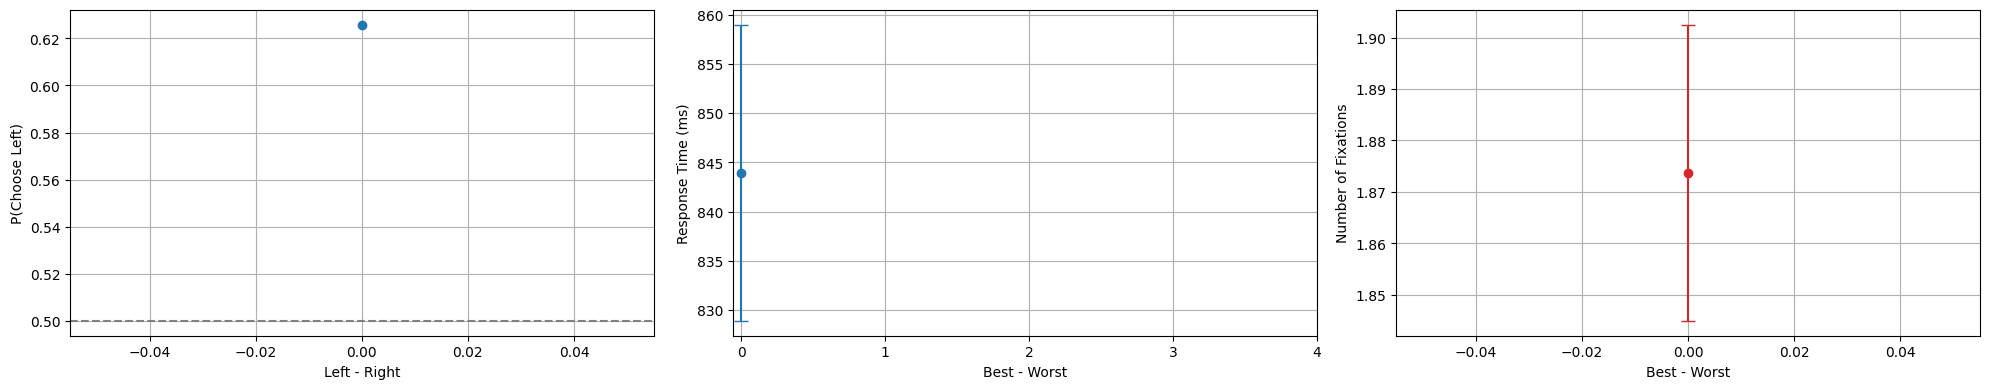

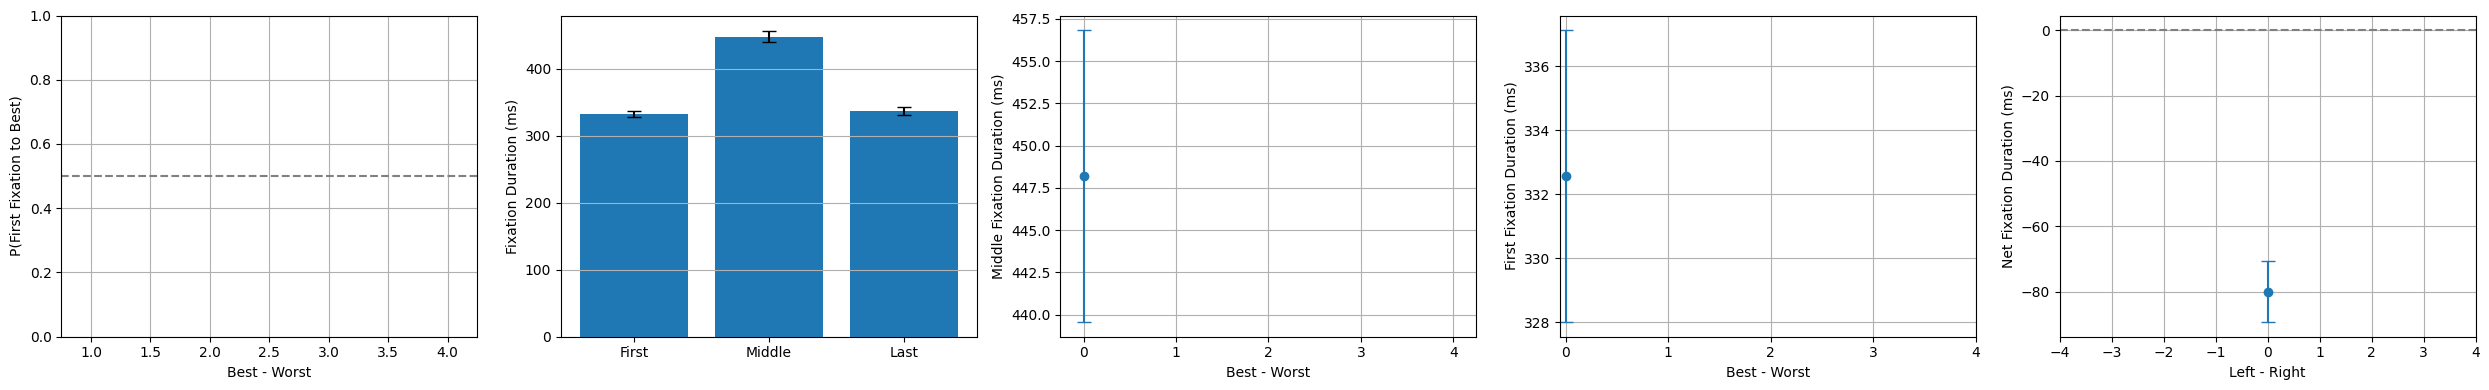

In [8]:
from mfa import plot_basic_psychometrics, plot_fixation_properties

plot_basic_psychometrics(efpt_rasterized)
plot_fixation_properties(efpt_rasterized)

As we can see, there only exists one breach of model independent analysis and that is with the net fixation duration. I bet that if we play around with the parameters, we might find something equitable, but I also propose an alternative. Perhaps the issue is with the stimuli value pairs represented in the data. From `DDM/exploratory_notebooks/grid_search.ipynb`, we know that trials with stimuli values 1 and 1 are overrepresented in the data. This may skew results and mask the fact that net fixation duration given high theta (one of many reasons) is uninformative. Otherwise, the idea of using empirical distributions from a specific experimental design may not be fit. `efficient-fpt` makes it (funnily enough), efficient to model addms under multiple scenarios whereas PyDDM requires a lot of manual definition.

In [ ]:
sub, p_l, first_fix, middle_fix, latencies, transitions